In [1]:
#dl.ipynb
#
#by Joe Hahn
#jmh.datasciences@gmail.com
#24 January 2018

In [2]:
#import matplotlib pandas etc
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
from matplotlib import rcParams
sns.set(font_scale=1.5, font='DejaVu Sans')
pd.set_option('display.max_columns', None)
pd.set_option('display.height', None)
pd.set_option('display.width', None)

height has been deprecated.



In [3]:
#read books dataframe
import pickle
with open('chunks.pkl', 'rb') as fp:
    chunks = pickle.load(fp)
print 'number of records = ', len(chunks)
print 'number of books = ', len(chunks['input_file'].unique())
chunks.head()

number of records =  126114
number of books =  89


,author,author_id,title,input_file,text_chunk
53137,Thomas Bulfinch,79,Bulfinch'S Mythology,iso/etext04/bllfn10.txt,shield prove thee the same who spread such sla...
15081,Herman Melville,38,Moby Dick,iso/etext01/moby11.txt,No dignity in whaling? The dignity of our call...
122479,Carl Von Clausewitz,11,On War,iso/etext99/1onwr10.txt,to that amphibious organisation which we call ...
34719,Immanuel Kant,42,The Critique Of Pure Reason,iso/etext03/cprrn10.txt,which I have named figurative synthesis. This ...
103631,Miquel De Cervantes,62,Don Quixote,iso/etext97/1donq10.txt,"of our vigils, lust and lewdness by the loyalt..."


In [4]:
#show titles and number of chunks
#need to fix Austnn & Jane Austen
N = pd.DataFrame(chunks.groupby(['author', 'title', 'input_file'])['text_chunk'].count()).reset_index()\
    .sort_values('author')
N = N.rename(columns={'text_chunk':'N_chunks'})
N.head()

,author,title,input_file,N_chunks
0,A.H. Clough,Plutarch's Lives,iso/etext96/plivs10.txt,2200
1,Adam Smith,Wealth Of Nations,iso/etext02/wltnt10.txt,2200
2,Adams,The Education Of Henry Adams,iso/etext00/eduha10.txt,1260
3,Anne C. Lynch Botta,Handbook Of Universal Literature,iso/etext05/8unlt10.txt,1699
4,Anthony Trollope,The Last Chronicle Of Barset,iso/etext02/lacob11.txt,2200


In [5]:
#select 3 books
records = chunks
id0 = 12 #Don Quijote in Spanish
id1 = 79 #bullfinch Mythology
id2 = 82 #Le Mort D'Arthur
idx = (records['author_id'] == id0) | (records['author_id'] == id1) | (records['author_id'] == id2)
records = records[idx].copy()
records['author_id'] = records['author_id'].replace({id0:0, id1:1, id2:2})#, axis=1)
records.head(20)

,author,author_id,title,input_file,text_chunk
53137,Thomas Bulfinch,1,Bulfinch'S Mythology,iso/etext04/bllfn10.txt,shield prove thee the same who spread such sla...
125205,"Cervantes, In Spanish",0,Don Quijote,iso/etext99/2donq10.txt,"en una cosa, y es que me pintaste mal su hermo..."
52992,Thomas Bulfinch,1,Bulfinch'S Mythology,iso/etext04/bllfn10.txt,"their money to themselves, and gave no share t..."
52896,Thomas Bulfinch,1,Bulfinch'S Mythology,iso/etext04/bllfn10.txt,"castle under which he passed, were the dupes o..."
111437,Thomas Malory,2,Le Mort D'Arthur,iso/etext98/2mart10.txt,realm of the world; for when they depart from ...
124597,"Cervantes, In Spanish",0,Don Quijote,iso/etext99/2donq10.txt,"de la por m�, y no por �l, enga�ada Antonomasi..."
111174,Thomas Malory,2,Le Mort D'Arthur,iso/etext98/2mart10.txt,and that caused him to lose a great part of hi...
123658,"Cervantes, In Spanish",0,Don Quijote,iso/etext99/2donq10.txt,"ni fundado en desvariadas imaginaciones, supl�..."
53510,Thomas Bulfinch,1,Bulfinch'S Mythology,iso/etext04/bllfn10.txt,"will come to some inhabited place, where I may..."
52463,Thomas Bulfinch,1,Bulfinch'S Mythology,iso/etext04/bllfn10.txt,"became of course very common, and errors of ge..."


In [6]:
#select 10 books
records = pd.DataFrame()
old_ids = [11, 78, 81, 8, 10, 20, 30, 40, 50, 70]
for new_id in range(len(old_ids)):
    idx = chunks['author_id'] == old_ids[new_id]
    df = chunks[idx].copy()
    df['author_id'] = new_id
    records = records.append(df, ignore_index=True)
records = records.sample(frac=1.0)
print records['title'].unique()
print 'number of records = ', len(records)
records.head(20)

['Science & Education' 'Life Of Luther' 'Unbeaten Tracks In Japan'
 'Sister Carrie' 'The Iliad' 'The Zambesi Expedition'
 'History Of American Literature' 'The Rosary' 'On War' 'The Caxtons']
number of records =  9967


,author,author_id,title,input_file,text_chunk
2536,Thomas H. Huxley,2,Science & Education,iso/etext04/8sced10.txt,respectability) the British father denies his ...
8667,Julius Koestlin,8,Life Of Luther,iso/etext05/8luth10.txt,"a Holy Catholic Church, the communion of saint..."
3192,Bird,3,Unbeaten Tracks In Japan,iso/etext00/utrkj10.txt,"or festival, in honour of the birthday of the ..."
2467,Thomas H. Huxley,2,Science & Education,iso/etext04/8sced10.txt,"are supplemented by that long-continued, patie..."
1794,Theodore Dreiser,1,Sister Carrie,iso/etext95/scarr10.txt,table was clean laid with linen and napery and...
6937,Homer,7,The Iliad,iso/etext04/iliad10a.txt,"no firmness, the pale coward shows; He shifts ..."
5726,David Livingstone,5,The Zambesi Expedition,iso/etext01/zambs10.txt,"request, the fear previously shown by the byst..."
1417,Theodore Dreiser,1,Sister Carrie,iso/etext95/scarr10.txt,"us plenty of money."" ""Can't we save?"" said Car..."
1986,Thomas H. Huxley,2,Science & Education,iso/etext04/8sced10.txt,"pulse, and of the course of the blood, put for..."
9620,Reuben Post Halleck,9,History Of American Literature,iso/etext04/mrclt10.txt,the war there was no universal free common sch...


In [7]:
#train-test-validate split
train_size = 0.33
validate_size=0.5   #this is the fraction of the test sample that is assigned to the validation sample
rn_seed = 12
from sklearn.model_selection import train_test_split
train, test = train_test_split(records, train_size=train_size, random_state=rn_seed)
validate, test = train_test_split(test, train_size=validate_size, random_state=rn_seed)
print 'records.shape  = ', records.shape
print 'train.shape    = ', train.shape
print 'test.shape     = ', test.shape
print 'validate.shape = ', validate.shape

records.shape  =  (9967, 5)
train.shape    =  (3289, 5)
test.shape     =  (3339, 5)
validate.shape =  (3339, 5)


In [8]:
#confirm that all 90 books have records in the training sample
print len(train['input_file'].unique()), len(records['input_file'].unique())

10 10


In [86]:
#count number of distinct workds in training data...43K
from collections import defaultdict
word_frequency = defaultdict(int)
corpus = train['text_chunk'].tolist()
for doc in corpus:
    words = doc.split(' ')
    for word in words:
        word_frequency[word] += 1
print 'number of distinct words = ', len(word_frequency.keys()) 
for word in word_frequency.keys()[1:7]:
    print word, word_frequency[word]

number of distinct words =  43307
lenitives 1
considered. 3
cords, 1
Poetry 1
woods 8
clotted 1


In [87]:
#generate tokenizer
vocabulary_size = 43000
N_inputs = 100
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(corpus)

In [88]:
#this helper function extracts and tokenizes x, and extracts y and onehot-encodes it
from keras.utils import np_utils
def tokenize(df, tokenizer):
    corpus = df['text_chunk'].tolist()
    corpus_tokenized = tokenizer.texts_to_sequences(corpus)
    corpus_padded = pad_sequences(corpus_tokenized, maxlen=N_inputs)
    x = np.array(corpus_padded)
    y_ids = df['author_id'].values
    y = np_utils.to_categorical(y_ids)
    return x, y

In [89]:
#get training x,y with x-values being tokenized and y values onehot-encoded
x_train, y_train = tokenize(train, tokenizer)
N_inputs = x_train.shape[1]
N_outputs = y_train.shape[1]
print 'x_train.shape = ', x_train.shape
print 'y_train.shape = ', y_train.shape
print 'N_inputs = ', N_inputs
print 'N_outputs = ', N_outputs
print 'vocabulary_size = ', vocabulary_size, x_train.min(), x_train.max()

x_train.shape =  (3289, 100)
y_train.shape =  (3289, 10)
N_inputs =  100
N_outputs =  10
vocabulary_size =  43000 0 21723


In [90]:
#display a training record
idx = 121
print train.iloc[idx]
text_chunk = train.iloc[idx]['text_chunk']
print text_chunk
print x_train[idx]
print y_train[idx]

author                                        David Livingstone
author_id                                                     5
title                                    The Zambesi Expedition
input_file                              iso/etext01/zambs10.txt
text_chunk    measure the Bishop decided to place his Missio...
Name: 5366, dtype: object
measure the Bishop decided to place his Mission Station on a small promontory formed by the windings of the little, clear stream of Magomero, which was so cold that the limbs were quite benumbed by washing in it in the July mornings. The site chosen was a pleasant spot to the eye, and completely surrounded by stately, shady trees. It was expected to serve for a residence, till the Bishop had acquired an accurate knowledge of the adjacent country, and of the political relations of the people, and could select a healthy and commanding situation, as a permanent centre of 
[ 1351     1  1373  1120     4   142     8  1825  1459    17     5   236
 2160

In [91]:
#show that the vectorized text preserves word order with punctuation dropping 
tokens = []
words_marked = text_chunk.split(' ')[0:4]
words = [word.lower().strip(',').strip('.').strip('"') for word in words_marked]
tokens = [tokenizer.word_index[word] for word in words]
print words
print tokens

['measure', 'the', 'bishop', 'decided']
[1351, 1, 1373, 1120]


In [92]:
#get validation x,y with x-values being tokenized and y values onehot-encoded
x_valid, y_valid = tokenize(validate, tokenizer)
print 'x_valid.shape = ', x_valid.shape
print 'y_valid.shape = ', y_valid.shape

x_valid.shape =  (3339, 100)
y_valid.shape =  (3339, 10)


In [93]:
#display a validation record
idx = 123
print validate.iloc[idx]
print validate.iloc[idx]['text_chunk']
print x_valid[321]
print y_valid[321]

author                                      Carl Von Clausewitz
author_id                                                     0
title                                                    On War
input_file                              iso/etext99/1onwr10.txt
text_chunk    to which it relates. Where great forces and gr...
Name: 249, dtype: object
to which it relates. Where great forces and great passions are wanting, it is certainly easier for a practised dexterity to show its game; but is then the command of great forces, not in itself a higher exercise of the intelligent faculties? Is then that kind of conventional sword-exercise not comprised in and belonging to the other mode of conducting War? Does it not bear the same relation to it as the motions upon a ship to the motion of the ship itself? Truly it can take place only under the tacit condition that the adversary does no better. And 
[  802    87     5  7323   106    32    40    28   274    25  4963     1
  4245    40   357     1  

In [222]:
#this LSTM model was adapted from 
#http://www.developintelligence.com/blog/2017/06/practical-neural-networks-keras-classifying-yelp-reviews
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from keras.models import Sequential
def build_lstm_model(N_inputs, N_outputs, vocabulary_size, embedding_vector_length, conv_kernel_size, dropout_fraction):
    model = Sequential()
    model.add(Embedding(vocabulary_size, embedding_vector_length, input_length=N_inputs))
    conv_layer_size = embedding_vector_length/2
    model.add(Conv1D(conv_layer_size, conv_kernel_size, activation='relu'))
    model.add(Dropout(dropout_fraction))
    pool_size = int(conv_kernel_size/2)
    model.add(MaxPooling1D(pool_size=pool_size))
    lstm_size = int(embedding_vector_length/2)
    model.add(LSTM(lstm_size, activation='tanh')) #try linear, tanh, relu
    model.add(Dropout(dropout_fraction))
    model.add(Dense(N_outputs, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [223]:
#####assemble lstm model
N_training_epochs = 200
batch_size = 200000
embedding_vector_length = 300#100
conv_kernel_size = 30
dropout_fraction = 0.7#0.6
rn_seed = 16
print 'N_training_epochs = ', N_training_epochs
print 'batch_size = ', batch_size
print 'number of training + validation samples = ', x_train.shape[0] + x_valid.shape[0]
print 'vocabulary_size = ', vocabulary_size
print 'embedding_vector_length = ', embedding_vector_length
print 'conv_kernel_size = ', conv_kernel_size
print 'dropout_fraction = ', dropout_fraction
print 'N_inputs = ', N_inputs, x_train.shape[1]
print 'N_outputs = ', N_outputs, y_train.shape[1]
print 'rn_seed = ', rn_seed
import random
random.seed(rn_seed)
lstm_model = build_lstm_model(N_inputs, N_outputs, vocabulary_size, embedding_vector_length, conv_kernel_size,
    dropout_fraction)

N_training_epochs =  400
batch_size =  200000
number of training + validation samples =  6628
vocabulary_size =  43000
embedding_vector_length =  100
conv_kernel_size =  30
dropout_fraction =  0.6
N_inputs =  100 100
N_outputs =  10 10
rn_seed =  16


In [224]:
#fit model to the training data
fit_history = lstm_model.fit(x_train, y_train, epochs=N_training_epochs, batch_size=batch_size, verbose=0, \
    validation_data=(x_valid, y_valid))

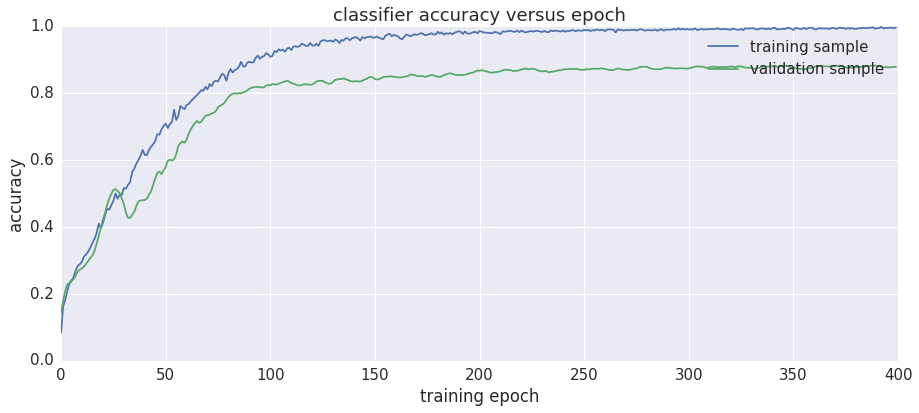

In [225]:
#plot accuracy vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['acc']
ax.plot(xp, yp, label='training sample')
yp = fit_history.history['val_acc']
ax.plot(xp, yp, label='validation sample')
ax.set_title('classifier accuracy versus epoch')
ax.set_ylabel('accuracy')
ax.set_xlabel('training epoch')
ax.legend()
plt.savefig('figs/accuracy.png')

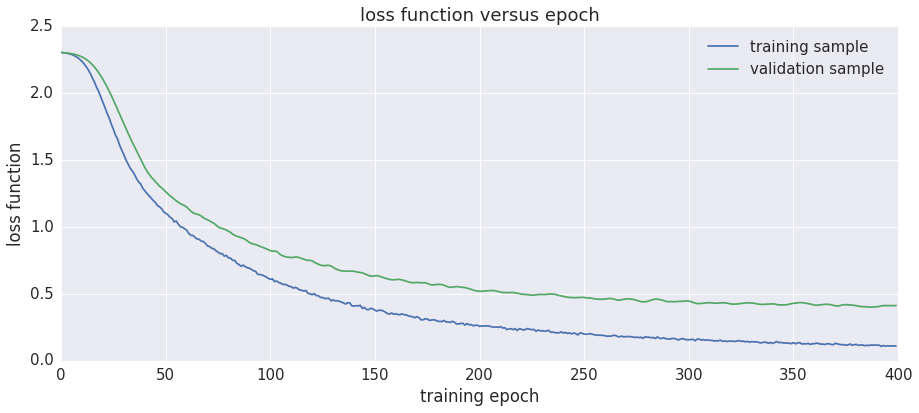

In [226]:
#plot loss function vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
ax.plot(xp, yp, label='training sample')
yp = fit_history.history['val_loss']
ax.plot(xp, yp, label='validation sample')
ax.set_title('loss function versus epoch')
ax.set_ylabel('loss function')
ax.set_xlabel('training epoch')
ax.legend()
plt.savefig('figs/loss.png')

In [221]:
#model.predict(x_test)